In [ ]:
# https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17

In [ ]:
import pandas as pd
import numpy as np
import pickle


In [ ]:
!pip install fuzzywuzzy

In [ ]:
from fuzzywuzzy import process

In [ ]:
d1 = pd.read_csv('sentiment_tweets3.csv')
d1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10314 entries, 0 to 10313
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Index                      10314 non-null  int64 
 1   message to examine         10314 non-null  object
 2   label (depression result)  10314 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 241.9+ KB


In [ ]:
d1 = d1.rename(columns={'message to examine':'body','label (depression result)':'Depressed'})

In [ ]:
d1.Depressed.value_counts()

0    8000
1    2314
Name: Depressed, dtype: int64

In [ ]:
d2 = pd.read_csv('Data.csv')
d2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1912 entries, 0 to 1911
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         1912 non-null   object 
 1   score         1912 non-null   int64  
 2   id            1912 non-null   object 
 3   subreddit     1912 non-null   object 
 4   url           1912 non-null   object 
 5   num_comments  1912 non-null   int64  
 6   body          1912 non-null   object 
 7   created       1912 non-null   float64
 8   Depressed     1912 non-null   int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 134.6+ KB


In [ ]:
d2 = d2.rename(columns={'label (depression result)':'Depressed', 'message to examine': 'body'})

In [ ]:
d2

,title,score,id,subreddit,url,num_comments,body,created,Depressed
0,Our most-broken and least-understood rules is ...,2323,doqwow,depression,https://www.reddit.com/r/depression/comments/d...,175,We understand that most people who reply immed...,1.572361e+09,1
1,"Regular Check-In Post, with important reminder...",672,m246c4,depression,https://www.reddit.com/r/depression/comments/m...,2584,Welcome to /r/depression's check-in post - a p...,1.615400e+09,1
2,Work is a perfect reason to commit suicide,628,oyqbtv,depression,https://www.reddit.com/r/depression/comments/o...,102,It sucks and it will be the majority of your l...,1.628193e+09,1
3,anyone else at their lowest?,63,oyxdxb,depression,https://www.reddit.com/r/depression/comments/o...,20,these past 3 days have been rough. I have new ...,1.628216e+09,1
4,Im burned out.,22,oz056o,depression,https://www.reddit.com/r/depression/comments/o...,4,Im so fucking tired of everything. Had a panic...,1.628227e+09,1
...,...,...,...,...,...,...,...,...,...
1907,What's something you do when noone is looking?,3,oz04n9,AskReddit,https://www.reddit.com/r/AskReddit/comments/oz...,12,What's something you do when noone is looking?,1.628227e+09,0
1908,If you had to eat one type of canned food for ...,6,oyxjy0,AskReddit,https://www.reddit.com/r/AskReddit/comments/oy...,23,If you had to eat one type of canned food for ...,1.628217e+09,0
1909,"People of Reddit, what do you think of virtue ...",4,oyypzt,AskReddit,https://www.reddit.com/r/AskReddit/comments/oy...,24,"People of Reddit, what do you think of virtue ...",1.628221e+09,0
1910,Who or what do you trust the most?,6,oyuxy4,AskReddit,https://www.reddit.com/r/AskReddit/comments/oy...,24,Who or what do you trust the most?,1.628207e+09,0


In [ ]:
d2.Depressed.value_counts()

0    996
1    916
Name: Depressed, dtype: int64

In [ ]:
d1 = d1[['body','Depressed']]
d2 = d2[['body','Depressed']]
df = pd.concat([d1,d2])

In [ ]:
df.Depressed.value_counts()

0    8996
1    3230
Name: Depressed, dtype: int64

In [ ]:
import spacy
#loading the english language small model of spacy
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words

In [ ]:
import re
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

def fuzzy(text):
  str2match = text
  stroptions = words
  Ratios = process.extract(str2match,stroptions)
  highest = preocess.extractOne(,str2matchstroptions)
  return highaest[0]

def clean_text(text):
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    words = [word for word in text.split() if word.lower() not in sw_spacy]
    text = " ".join(words)
    return text
  

df['body'] = df['body'].apply(clean_text)
df['body'] = df['body'].str.replace('\d+', '')

In [ ]:
df

,body,Depressed
0,real good moment missssssssss,0
1,reading manga http plurkcom p mzpe,0
2,comeagainjen http twitpiccom yl http wwwyoutub...,0
3,lapcat need send em accountant tomorrow oddly ...,0
4,add myspace myspacecom lookthunder,0
...,...,...
12221,whats looking,0
12222,eat type canned food rest life choosing,0
12223,people reddit think virtue signalling fau outr...,0
12224,trust,0


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['body'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 27141 unique tokens.


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X = tokenizer.texts_to_sequences(df['body'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (12226, 250)


In [ ]:
Y = pd.get_dummies(df['Depressed']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (12226, 2)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(9169, 250) (9169, 2)
(3057, 250) (3057, 2)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 4
batch_size = 512

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/4
17/17 [==============================] - 70s 4s/step - loss: 0.5844 - accuracy: 0.7196 - val_loss: 0.4554 - val_accuracy: 0.7710
Epoch 2/4
17/17 [==============================] - 65s 4s/step - loss: 0.4037 - accuracy: 0.8427 - val_loss: 0.3266 - val_accuracy: 0.9008
Epoch 3/4
17/17 [==============================] - 66s 4s/step - loss: 0.2748 - accuracy: 0.9118 - val_loss: 0.2152 - val_accuracy: 0.9411
Epoch 4/4
17/17 [==============================] - 66s 4s/step - loss: 0.1366 - accuracy: 0.9547 - val_loss: 0.1092 - val_accuracy: 0.9553


In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

96/96 [==============================] - 8s 80ms/step - loss: 0.1206 - accuracy: 0.9519
Test set
  Loss: 0.121
  Accuracy: 0.952


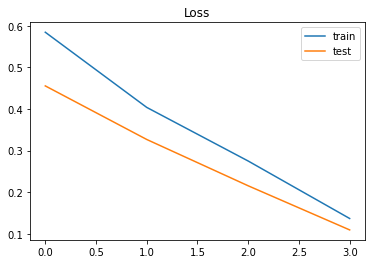

In [ ]:
import matplotlib.pyplot as plt
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

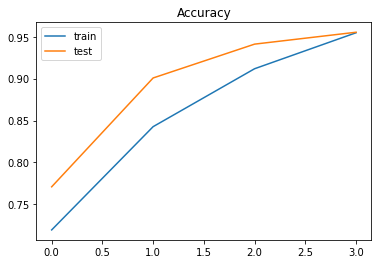

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [ ]:
val = pd.read_csv('shot2.csv')

In [ ]:
val

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I don't get affected by compliments...,non-suicide
2,Finally 2020 is almost over... So I can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide
...,...,...
5831,I have a theory guys... Girls just say they ar...,non-suicide
5832,Aussie Goth/Punk Clothing Store (13F) Im tryna...,non-suicide
5833,Either this place get its shit together or we ...,non-suicide
5834,Why was 2019 scared of 2020 Because they had a...,non-suicide


In [ ]:
val['Depressed'] = 0
for i in range(len(val)):
  if(val.loc[i,'class'] == 'suicide'):
    val.loc[i,'Depressed'] = 1
val = val.rename(columns = {'text':'body'})
val = val[['body','Depressed']]

In [ ]:
val

,body,Depressed
0,Ex Wife Threatening SuicideRecently I left my ...,1
1,Am I weird I don't get affected by compliments...,0
2,Finally 2020 is almost over... So I can never ...,0
3,i need helpjust help me im crying so hard,1
4,"I’m so lostHello, my name is Adam (16) and I’v...",1
...,...,...
5831,I have a theory guys... Girls just say they ar...,0
5832,Aussie Goth/Punk Clothing Store (13F) Im tryna...,0
5833,Either this place get its shit together or we ...,0
5834,Why was 2019 scared of 2020 Because they had a...,0


In [ ]:
val['body'] = val['body'].apply(clean_text)
val['body'] = val['body'].str.replace('\d+', '')
X1 = tokenizer.texts_to_sequences(val['body'].values)
X1 = pad_sequences(X1, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X1.shape)
Y1 = pd.get_dummies(val['Depressed']).values
print('Shape of label tensor:', Y1.shape)

Shape of data tensor: (5836, 250)
Shape of label tensor: (5836, 2)


In [ ]:
accr = model.evaluate(X1,Y1)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

183/183 [==============================] - 14s 76ms/step - loss: 0.9798 - accuracy: 0.7282
Test set
  Loss: 0.980
  Accuracy: 0.728


In [ ]:
def isDepressing(text):
  lst = {'body':[text]}
  # Calling DataFrame constructor on list  
  dframe = pd.DataFrame(lst) 
  dframe = dframe['body'].apply(clean_text)
  dframe = dframe.str.replace('\d+', '')
  X1 = tokenizer.texts_to_sequences(dframe.values)
  X1 = pad_sequences(X1, maxlen=MAX_SEQUENCE_LENGTH)
  print('Shape of data tensor:', X1.shape)
  a = model.predict(X1)
  print(a)
  if(a[0][0] > a[0][1]):
    return 0
  return 1

In [ ]:
isDepressing('i just want to die. I dont want to burden my family anymore')

Shape of data tensor: (1, 250)
[[0.0250965 0.9749035]]


1

In [ ]:
pickle.dump(words,open('words.pkl','wb'))
pickle.dump(df,open('df.pkl','wb'))
